

# How To Use Stackix
Stackeix is our implementation of a stacked/hierachial autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extenisve, because
our pipeline works similar for different architecture, so here we focus only on Stackix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Stackix pipeline. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.

## Stackix Theory

In our implementation, we train one variational autoencoder (VAE) per data modality end-to-end. The latent spaces of these *outer* autoencoders are then concatenated and used as input to another *inner* autoencoder. We perform downstream visualization and evaluation on this **meta-latent space**.  

For unpaired data, each outer autoencoder is trained on all available samples of its modality, even if the corresponding sample is missing in the other modalities. When constructing the input for the inner autoencoder, we drop non-overlapping samples to ensure consistency across modalities.  

This approach has two goals:  
1. To produce more informative latent spaces for each modality.  
2. To provide a richer, joint representation for the inner autoencoder.  

We also store the dropped samples and their indices. This allows us to reconstruct the full dataset: the output of the inner autoencoder can be passed back through the outer autoencoders, where decoding recovers the original modalities.  


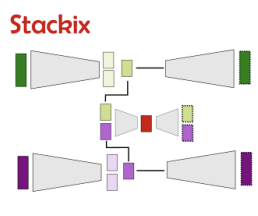. . 

---
## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run the pipeline. <br> <br>
2. Understand the Stackix sepecific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access the Varix specific **results** (sub-results for "outer" autoencoders). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 🚀

## 1) Initialize and Run Stackix
We set a few custom parameters of the config file. For a deep dive into the config object see: 

`Tutorials/DeepDives/ConfigTutorial.ipynb`

In [3]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

# Stackix has its own config class
# instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly.
# this time with single cell data
print("Input data:")
print(EXAMPLE_MULTI_BULK)
print("-" *50)
my_config = StackixConfig(
    epochs=27,
    checkpoint_interval=5,
    default_vae_loss="kl", # kl or mmd possible
    data_case=DataCase.MULTI_BULK,
)
print("\n")
print("Starting Pipeline")
print("-"*50)
print("-"*50)
stackix = acx.Stackix(data=EXAMPLE_MULTI_BULK, config=my_config)
result = stackix.run()

Input data:
multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
--------------------------------------------------


Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
--- Running Pairing-Aware Split ---
Identified 500 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 5609.8924
Sub-losses: recon_loss: 5609.8845, var_loss: 0.0079, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 520.0080
Sub-losses: recon_loss: 520.0076

## 2) Stackix Specific Steps
While Stackix has no extra/different steps in the pipeline. The prerpocessing and training step works a bit differntly than for the Varix or Vanillix. Furthermore is it possible to add paired and unpaired data (in comparison to only paired data for Vanillix and Varix).